In [25]:
import sys
import pickle
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from model import PMF, DRRAveStateRepresentation, Actor, Critic
from train import DRRTrainer

from utils.prioritized_replay_buffer import NaivePrioritizedReplayMemory, Transition
from utils.history_buffer import HistoryBuffer
%matplotlib inline

In [15]:
class config():
    ## hyperparameters
    ## setting the batch_size
    batch_size = 64
    gamma = 0.9
    replay_buffer_size = 100000
    history_buffer_size = 5
    learning_start = 100
    learning_freq = 1
    ## learning rate for each model networks
    lr_state_rep = 0.001
    lr_actor = 0.0001
    lr_critic = 0.001
    
    eps_start = 1
    eps = 0.1
    eps_steps = 10000
    eps_eval = 0.1
    episode_length = 10
    
    tau = 0.01 # inital 0.001
    beta = 0.4
    prob_alpha = 0.3
    
    max_timesteps_train = 260000
    max_epochs_offline = 500
    max_timesteps_online = 20000
    embedding_feature_size = 100
    
    train_ratio = 0.8
    clip_val = 1.0
    log_freq = 100
    saving_freq = 1000
    zero_reward = False
    
## First importing the data
users = pickle.load(open('dataset_RL/user_id_to_num.pkl', 'rb'))
items = pickle.load(open('dataset_RL/item_lookup.pkl', 'rb'))
# data = np.load('dataset_RL/data_RL_25000.npy')

train_data = np.load('dataset_RL/train_data_RL_75000.npy')
test_data = np.load('dataset_RL/test_data_RL_75000.npy')

## hold the length of the data
n_users = len(users)
n_items = len(items)

## don't forget to normalize the data first
# data[:, 2] = 0.5 * (data[:, 2] - 3)
train_data[:, 2] = 0.5 * (train_data[:, 2] - 3)
test_data[:, 2] = 0.5 * (test_data[:, 2] - 3)

## split and shuffle the data
# np.random.shuffle(data)
np.random.shuffle(train_data)
np.random.shuffle(test_data)

## split the data
## ratio should be 0.8
# train_data = tf.convert_to_tensor(data[:int(config.train_ratio * data.shape[0])], dtype='float32')
# test_data = tf.convert_to_tensor(data[int(config.train_ratio * data.shape[0]):], dtype='float32')

train_data = tf.convert_to_tensor(train_data, dtype='float32')
test_data = tf.convert_to_tensor(test_data, dtype='float32')
print("Train Data:{}, Test Data:{}".format(np.shape(train_data), np.shape(test_data)))

## hold the PMF model
## get the user and item embeddings
reward_function = PMF(n_users, n_items, config.embedding_feature_size)
## need to flow some data to build the model
reward_function(1, 1)
## loading the whole layer weights
reward_function.load_weights('trained/pmf_weights/oversampling/pmf_oversampling_undersampling')
## freeze the model, because it will be used for inference
reward_function.trainable = False

## take the embedding layers weight
## and split the user and item weights
user_embeddings = tf.convert_to_tensor(reward_function.user_embedding.get_weights()[0])
item_embeddings = tf.convert_to_tensor(reward_function.item_embedding.get_weights()[0])
## output
print("user embedding has shape {} and item embedding has shape {}"
      .format(np.shape(user_embeddings), np.shape(item_embeddings)))

## hold the model in the variable
## so it can be tracked
state_rep_function = DRRAveStateRepresentation
actor_function = Actor
critic_function = Critic

## initialize DRRTrain Class
trainer = DRRTrainer(config,
                     actor_function,
                     critic_function,
                     state_rep_function,
                     reward_function,
                     users,
                     items,
                     train_data,
                     test_data,
                     user_embeddings,
                     item_embeddings)

# print("Start Training")
# actor_losses, critic_losses, epi_avg_rewards = trainer.learn()

Train Data:(39592, 3), Test Data:(15101, 3)
user embedding has shape (822, 100) and item embedding has shape (142, 100)
Actor-Critic model has successfully instantiated
DRR Instantiazed


In [17]:
T_precisions = [5, 10, 15, 20]

for T_precision in T_precisions:
    drr_Ts = []
    for i in range(20):
        # Evaluate
        avg_precision = trainer.offline_evaluate(T_precision)
        # Append to list
        drr_Ts.append(avg_precision)

    # Save data
    drr_Ts = np.array(drr_Ts)
    np.save('logs/' + f'avg_precision@{T_precision}_offline_eval.npy', drr_Ts)

    # Save
    sourceFile = open("results/" + f'avg_precision@{T_precision}_offline_eval.txt', 'w')
    print(f'Average Precision@{T_precision} (Eval): {np.mean(drr_Ts)}', file=sourceFile)
    sourceFile.close()

Episode 10 | Precision@5 0.6 | Avg Precision@5 0.7200 | 
Episode 20 | Precision@5 0.6 | Avg Precision@5 0.6950 | 
Episode 30 | Precision@5 0.6 | Avg Precision@5 0.7033 | 
Episode 40 | Precision@5 0.7 | Avg Precision@5 0.7050 | 
Episode 50 | Precision@5 0.7 | Avg Precision@5 0.6900 | 
Episode 60 | Precision@5 0.8 | Avg Precision@5 0.6967 | 
Episode 70 | Precision@5 0.7 | Avg Precision@5 0.7057 | 
Episode 80 | Precision@5 0.8 | Avg Precision@5 0.7137 | 
Episode 90 | Precision@5 0.8 | Avg Precision@5 0.7067 | 
Episode 100 | Precision@5 0.3 | Avg Precision@5 0.6990 | 
Episode 110 | Precision@5 0.7 | Avg Precision@5 0.6991 | 
Episode 120 | Precision@5 0.6 | Avg Precision@5 0.7008 | 
Episode 130 | Precision@5 0.7 | Avg Precision@5 0.7069 | 
Episode 140 | Precision@5 0.8 | Avg Precision@5 0.7064 | 
Episode 150 | Precision@5 0.5 | Avg Precision@5 0.7053 | 
Episode 160 | Precision@5 0.6 | Avg Precision@5 0.7075 | 
Episode 170 | Precision@5 0.8 | Avg Precision@5 0.7035 | 
Episode 180 | Precision

Episode 410 | Precision@5 0.7 | Avg Precision@5 0.6966 | 
Episode 420 | Precision@5 0.6 | Avg Precision@5 0.6952 | 
Episode 430 | Precision@5 0.6 | Avg Precision@5 0.6940 | 
Episode 440 | Precision@5 0.7 | Avg Precision@5 0.6950 | 
Episode 450 | Precision@5 0.5 | Avg Precision@5 0.6942 | 
Episode 460 | Precision@5 0.7 | Avg Precision@5 0.6965 | 
Episode 470 | Precision@5 0.8 | Avg Precision@5 0.6960 | 
Episode 480 | Precision@5 0.8 | Avg Precision@5 0.6977 | 
Episode 490 | Precision@5 0.6 | Avg Precision@5 0.6988 | 
Episode 500 | Precision@5 0.8 | Avg Precision@5 0.6978 | 
Offline Evaluation Finished
Average Precision@5: 0.6982 | 
Episode 10 | Precision@5 0.8 | Avg Precision@5 0.6400 | 
Episode 20 | Precision@5 0.7 | Avg Precision@5 0.7100 | 
Episode 30 | Precision@5 0.6 | Avg Precision@5 0.7067 | 
Episode 40 | Precision@5 0.8 | Avg Precision@5 0.7050 | 
Episode 50 | Precision@5 0.6 | Avg Precision@5 0.6920 | 
Episode 60 | Precision@5 0.7 | Avg Precision@5 0.6983 | 
Episode 70 | Precis

Episode 300 | Precision@5 0.5 | Avg Precision@5 0.6970 | 
Episode 310 | Precision@5 0.7 | Avg Precision@5 0.6935 | 
Episode 320 | Precision@5 0.6 | Avg Precision@5 0.6937 | 
Episode 330 | Precision@5 0.7 | Avg Precision@5 0.6979 | 
Episode 340 | Precision@5 0.7 | Avg Precision@5 0.6959 | 
Episode 350 | Precision@5 0.8 | Avg Precision@5 0.6966 | 
Episode 360 | Precision@5 0.7 | Avg Precision@5 0.6961 | 
Episode 370 | Precision@5 0.9 | Avg Precision@5 0.6984 | 
Episode 380 | Precision@5 0.6 | Avg Precision@5 0.6961 | 
Episode 390 | Precision@5 0.7 | Avg Precision@5 0.6941 | 
Episode 400 | Precision@5 0.6 | Avg Precision@5 0.6930 | 
Episode 410 | Precision@5 0.7 | Avg Precision@5 0.6917 | 
Episode 420 | Precision@5 0.7 | Avg Precision@5 0.6914 | 
Episode 430 | Precision@5 0.9 | Avg Precision@5 0.6944 | 
Episode 440 | Precision@5 0.6 | Avg Precision@5 0.6943 | 
Episode 450 | Precision@5 0.9 | Avg Precision@5 0.6944 | 
Episode 460 | Precision@5 0.7 | Avg Precision@5 0.6948 | 
Episode 470 | 

Episode 190 | Precision@5 0.4 | Avg Precision@5 0.6837 | 
Episode 200 | Precision@5 0.9 | Avg Precision@5 0.6860 | 
Episode 210 | Precision@5 0.6 | Avg Precision@5 0.6857 | 
Episode 220 | Precision@5 0.4 | Avg Precision@5 0.6841 | 
Episode 230 | Precision@5 0.7 | Avg Precision@5 0.6826 | 
Episode 240 | Precision@5 0.9 | Avg Precision@5 0.6858 | 
Episode 250 | Precision@5 0.7 | Avg Precision@5 0.6848 | 
Episode 260 | Precision@5 0.6 | Avg Precision@5 0.6850 | 
Episode 270 | Precision@5 0.7 | Avg Precision@5 0.6830 | 
Episode 280 | Precision@5 0.9 | Avg Precision@5 0.6832 | 
Episode 290 | Precision@5 0.5 | Avg Precision@5 0.6866 | 
Episode 300 | Precision@5 0.6 | Avg Precision@5 0.6860 | 
Episode 310 | Precision@5 0.8 | Avg Precision@5 0.6845 | 
Episode 320 | Precision@5 0.6 | Avg Precision@5 0.6863 | 
Episode 330 | Precision@5 0.6 | Avg Precision@5 0.6855 | 
Episode 340 | Precision@5 0.7 | Avg Precision@5 0.6835 | 
Episode 350 | Precision@5 0.7 | Avg Precision@5 0.6840 | 
Episode 360 | 

Episode 80 | Precision@5 0.4 | Avg Precision@5 0.6950 | 
Episode 90 | Precision@5 0.9 | Avg Precision@5 0.7011 | 
Episode 100 | Precision@5 0.7 | Avg Precision@5 0.7060 | 
Episode 110 | Precision@5 0.8 | Avg Precision@5 0.7036 | 
Episode 120 | Precision@5 0.5 | Avg Precision@5 0.6992 | 
Episode 130 | Precision@5 0.7 | Avg Precision@5 0.6962 | 
Episode 140 | Precision@5 0.7 | Avg Precision@5 0.6900 | 
Episode 150 | Precision@5 0.7 | Avg Precision@5 0.6913 | 
Episode 160 | Precision@5 0.6 | Avg Precision@5 0.6912 | 
Episode 170 | Precision@5 0.8 | Avg Precision@5 0.6982 | 
Episode 180 | Precision@5 0.4 | Avg Precision@5 0.6967 | 
Episode 190 | Precision@5 0.7 | Avg Precision@5 0.6953 | 
Episode 200 | Precision@5 0.9 | Avg Precision@5 0.6950 | 
Episode 210 | Precision@5 0.7 | Avg Precision@5 0.6990 | 
Episode 220 | Precision@5 0.4 | Avg Precision@5 0.6945 | 
Episode 230 | Precision@5 0.8 | Avg Precision@5 0.6978 | 
Episode 240 | Precision@5 0.9 | Avg Precision@5 0.6967 | 
Episode 250 | Pr

Episode 480 | Precision@5 0.8 | Avg Precision@5 0.7027 | 
Episode 490 | Precision@5 0.7 | Avg Precision@5 0.7018 | 
Episode 500 | Precision@5 0.5 | Avg Precision@5 0.7008 | 
Offline Evaluation Finished
Average Precision@5: 0.7008 | 
Episode 10 | Precision@5 0.8 | Avg Precision@5 0.7100 | 
Episode 20 | Precision@5 0.7 | Avg Precision@5 0.7300 | 
Episode 30 | Precision@5 0.7 | Avg Precision@5 0.7367 | 
Episode 40 | Precision@5 0.5 | Avg Precision@5 0.7175 | 
Episode 50 | Precision@5 0.5 | Avg Precision@5 0.7140 | 
Episode 60 | Precision@5 0.7 | Avg Precision@5 0.7117 | 
Episode 70 | Precision@5 0.7 | Avg Precision@5 0.7100 | 
Episode 80 | Precision@5 0.9 | Avg Precision@5 0.7113 | 
Episode 90 | Precision@5 0.8 | Avg Precision@5 0.7056 | 
Episode 100 | Precision@5 0.8 | Avg Precision@5 0.7080 | 
Episode 110 | Precision@5 0.6 | Avg Precision@5 0.7073 | 
Episode 120 | Precision@5 0.7 | Avg Precision@5 0.7050 | 
Episode 130 | Precision@5 0.5 | Avg Precision@5 0.6946 | 
Episode 140 | Precisio

Episode 370 | Precision@5 0.8 | Avg Precision@5 0.6989 | 
Episode 380 | Precision@5 0.9 | Avg Precision@5 0.7003 | 
Episode 390 | Precision@5 0.9 | Avg Precision@5 0.7008 | 
Episode 400 | Precision@5 0.7 | Avg Precision@5 0.7007 | 
Episode 410 | Precision@5 0.8 | Avg Precision@5 0.6995 | 
Episode 420 | Precision@5 0.8 | Avg Precision@5 0.6993 | 
Episode 430 | Precision@5 0.5 | Avg Precision@5 0.6988 | 
Episode 440 | Precision@5 0.5 | Avg Precision@5 0.6980 | 
Episode 450 | Precision@5 0.6 | Avg Precision@5 0.6973 | 
Episode 460 | Precision@5 0.9 | Avg Precision@5 0.6976 | 
Episode 470 | Precision@5 1.0 | Avg Precision@5 0.6977 | 
Episode 480 | Precision@5 0.4 | Avg Precision@5 0.6975 | 
Episode 490 | Precision@5 0.8 | Avg Precision@5 0.6973 | 
Episode 500 | Precision@5 1.0 | Avg Precision@5 0.6974 | 
Offline Evaluation Finished
Average Precision@5: 0.6978 | 
Episode 10 | Precision@5 0.5 | Avg Precision@5 0.7100 | 
Episode 20 | Precision@5 0.5 | Avg Precision@5 0.7000 | 
Episode 30 | Pr

Episode 260 | Precision@5 0.7 | Avg Precision@5 0.6958 | 
Episode 270 | Precision@5 0.6 | Avg Precision@5 0.6956 | 
Episode 280 | Precision@5 0.6 | Avg Precision@5 0.6921 | 
Episode 290 | Precision@5 0.9 | Avg Precision@5 0.6931 | 
Episode 300 | Precision@5 0.7 | Avg Precision@5 0.6937 | 
Episode 310 | Precision@5 0.6 | Avg Precision@5 0.6935 | 
Episode 320 | Precision@5 0.4 | Avg Precision@5 0.6916 | 
Episode 330 | Precision@5 0.5 | Avg Precision@5 0.6939 | 
Episode 340 | Precision@5 0.7 | Avg Precision@5 0.6932 | 
Episode 350 | Precision@5 0.8 | Avg Precision@5 0.6929 | 
Episode 360 | Precision@5 0.7 | Avg Precision@5 0.6919 | 
Episode 370 | Precision@5 0.4 | Avg Precision@5 0.6905 | 
Episode 380 | Precision@5 0.5 | Avg Precision@5 0.6903 | 
Episode 390 | Precision@5 0.5 | Avg Precision@5 0.6908 | 
Episode 400 | Precision@5 0.9 | Avg Precision@5 0.6922 | 
Episode 410 | Precision@5 0.5 | Avg Precision@5 0.6902 | 
Episode 420 | Precision@5 0.6 | Avg Precision@5 0.6912 | 
Episode 430 | 

Episode 110 | Precision@10 0.8 | Avg Precision@10 0.7073 | 
Episode 120 | Precision@10 0.6 | Avg Precision@10 0.7083 | 
Episode 130 | Precision@10 1.0 | Avg Precision@10 0.7108 | 
Episode 140 | Precision@10 0.8 | Avg Precision@10 0.7064 | 
Episode 150 | Precision@10 0.7 | Avg Precision@10 0.7087 | 
Episode 160 | Precision@10 0.8 | Avg Precision@10 0.7081 | 
Episode 170 | Precision@10 0.4 | Avg Precision@10 0.7065 | 
Episode 180 | Precision@10 0.5 | Avg Precision@10 0.7078 | 
Episode 190 | Precision@10 0.7 | Avg Precision@10 0.7089 | 
Episode 200 | Precision@10 0.9 | Avg Precision@10 0.7065 | 
Episode 210 | Precision@10 0.8 | Avg Precision@10 0.7100 | 
Episode 220 | Precision@10 0.7 | Avg Precision@10 0.7100 | 
Episode 230 | Precision@10 0.8 | Avg Precision@10 0.7078 | 
Episode 240 | Precision@10 0.6 | Avg Precision@10 0.7042 | 
Episode 250 | Precision@10 0.5 | Avg Precision@10 0.7056 | 
Episode 260 | Precision@10 0.8 | Avg Precision@10 0.7065 | 
Episode 270 | Precision@10 0.8 | Avg Pre

Episode 460 | Precision@10 0.8 | Avg Precision@10 0.7207 | 
Episode 470 | Precision@10 0.7 | Avg Precision@10 0.7204 | 
Episode 480 | Precision@10 0.8 | Avg Precision@10 0.7217 | 
Episode 490 | Precision@10 0.8 | Avg Precision@10 0.7216 | 
Episode 500 | Precision@10 0.9 | Avg Precision@10 0.7216 | 
Offline Evaluation Finished
Average Precision@10: 0.7212 | 
Episode 10 | Precision@10 0.8 | Avg Precision@10 0.6600 | 
Episode 20 | Precision@10 0.6 | Avg Precision@10 0.6700 | 
Episode 30 | Precision@10 0.9 | Avg Precision@10 0.6900 | 
Episode 40 | Precision@10 0.9 | Avg Precision@10 0.6875 | 
Episode 50 | Precision@10 0.9 | Avg Precision@10 0.6900 | 
Episode 60 | Precision@10 0.9 | Avg Precision@10 0.6983 | 
Episode 70 | Precision@10 0.8 | Avg Precision@10 0.7057 | 
Episode 80 | Precision@10 0.8 | Avg Precision@10 0.7100 | 
Episode 90 | Precision@10 0.8 | Avg Precision@10 0.7089 | 
Episode 100 | Precision@10 0.8 | Avg Precision@10 0.7090 | 
Episode 110 | Precision@10 0.9 | Avg Precision@10

Episode 300 | Precision@10 0.6 | Avg Precision@10 0.7343 | 
Episode 310 | Precision@10 0.7 | Avg Precision@10 0.7335 | 
Episode 320 | Precision@10 0.5 | Avg Precision@10 0.7319 | 
Episode 330 | Precision@10 0.8 | Avg Precision@10 0.7294 | 
Episode 340 | Precision@10 1.0 | Avg Precision@10 0.7297 | 
Episode 350 | Precision@10 0.8 | Avg Precision@10 0.7280 | 
Episode 360 | Precision@10 0.9 | Avg Precision@10 0.7283 | 
Episode 370 | Precision@10 0.5 | Avg Precision@10 0.7254 | 
Episode 380 | Precision@10 0.8 | Avg Precision@10 0.7247 | 
Episode 390 | Precision@10 0.9 | Avg Precision@10 0.7259 | 
Episode 400 | Precision@10 0.5 | Avg Precision@10 0.7252 | 
Episode 410 | Precision@10 0.8 | Avg Precision@10 0.7259 | 
Episode 420 | Precision@10 0.9 | Avg Precision@10 0.7262 | 
Episode 430 | Precision@10 0.9 | Avg Precision@10 0.7251 | 
Episode 440 | Precision@10 1.0 | Avg Precision@10 0.7250 | 
Episode 450 | Precision@10 0.6 | Avg Precision@10 0.7247 | 
Episode 460 | Precision@10 0.8 | Avg Pre

Episode 140 | Precision@10 0.8 | Avg Precision@10 0.7193 | 
Episode 150 | Precision@10 0.8 | Avg Precision@10 0.7193 | 
Episode 160 | Precision@10 0.8 | Avg Precision@10 0.7219 | 
Episode 170 | Precision@10 0.7 | Avg Precision@10 0.7206 | 
Episode 180 | Precision@10 0.9 | Avg Precision@10 0.7222 | 
Episode 190 | Precision@10 0.7 | Avg Precision@10 0.7221 | 
Episode 200 | Precision@10 0.5 | Avg Precision@10 0.7200 | 
Episode 210 | Precision@10 0.7 | Avg Precision@10 0.7233 | 
Episode 220 | Precision@10 0.8 | Avg Precision@10 0.7191 | 
Episode 230 | Precision@10 0.8 | Avg Precision@10 0.7178 | 
Episode 240 | Precision@10 0.9 | Avg Precision@10 0.7192 | 
Episode 250 | Precision@10 0.8 | Avg Precision@10 0.7188 | 
Episode 260 | Precision@10 0.6 | Avg Precision@10 0.7181 | 
Episode 270 | Precision@10 0.6 | Avg Precision@10 0.7193 | 
Episode 280 | Precision@10 0.9 | Avg Precision@10 0.7211 | 
Episode 290 | Precision@10 0.4 | Avg Precision@10 0.7203 | 
Episode 300 | Precision@10 0.7 | Avg Pre

Episode 490 | Precision@10 0.7 | Avg Precision@10 0.7257 | 
Episode 500 | Precision@10 0.8 | Avg Precision@10 0.7274 | 
Offline Evaluation Finished
Average Precision@10: 0.7275 | 
Episode 10 | Precision@10 0.6 | Avg Precision@10 0.6900 | 
Episode 20 | Precision@10 0.9 | Avg Precision@10 0.7200 | 
Episode 30 | Precision@10 0.8 | Avg Precision@10 0.7033 | 
Episode 40 | Precision@10 0.7 | Avg Precision@10 0.6975 | 
Episode 50 | Precision@10 0.8 | Avg Precision@10 0.7060 | 
Episode 60 | Precision@10 0.9 | Avg Precision@10 0.7133 | 
Episode 70 | Precision@10 0.6 | Avg Precision@10 0.7100 | 
Episode 80 | Precision@10 0.6 | Avg Precision@10 0.7125 | 
Episode 90 | Precision@10 0.7 | Avg Precision@10 0.7122 | 
Episode 100 | Precision@10 1.0 | Avg Precision@10 0.7150 | 
Episode 110 | Precision@10 0.8 | Avg Precision@10 0.7145 | 
Episode 120 | Precision@10 0.6 | Avg Precision@10 0.7158 | 
Episode 130 | Precision@10 0.7 | Avg Precision@10 0.7138 | 
Episode 140 | Precision@10 0.9 | Avg Precision@10

Episode 330 | Precision@10 0.7 | Avg Precision@10 0.7270 | 
Episode 340 | Precision@10 0.9 | Avg Precision@10 0.7282 | 
Episode 350 | Precision@10 0.8 | Avg Precision@10 0.7277 | 
Episode 360 | Precision@10 0.5 | Avg Precision@10 0.7272 | 
Episode 370 | Precision@10 0.6 | Avg Precision@10 0.7262 | 
Episode 380 | Precision@10 0.9 | Avg Precision@10 0.7266 | 
Episode 390 | Precision@10 0.8 | Avg Precision@10 0.7262 | 
Episode 400 | Precision@10 0.6 | Avg Precision@10 0.7255 | 
Episode 410 | Precision@10 0.7 | Avg Precision@10 0.7273 | 
Episode 420 | Precision@10 0.8 | Avg Precision@10 0.7262 | 
Episode 430 | Precision@10 1.0 | Avg Precision@10 0.7265 | 
Episode 440 | Precision@10 0.9 | Avg Precision@10 0.7264 | 
Episode 450 | Precision@10 0.6 | Avg Precision@10 0.7264 | 
Episode 460 | Precision@10 0.5 | Avg Precision@10 0.7252 | 
Episode 470 | Precision@10 0.6 | Avg Precision@10 0.7240 | 
Episode 480 | Precision@10 0.7 | Avg Precision@10 0.7233 | 
Episode 490 | Precision@10 0.8 | Avg Pre

Episode 170 | Precision@10 0.6 | Avg Precision@10 0.7259 | 
Episode 180 | Precision@10 0.7 | Avg Precision@10 0.7206 | 
Episode 190 | Precision@10 0.8 | Avg Precision@10 0.7163 | 
Episode 200 | Precision@10 0.7 | Avg Precision@10 0.7150 | 
Episode 210 | Precision@10 0.6 | Avg Precision@10 0.7095 | 
Episode 220 | Precision@10 0.8 | Avg Precision@10 0.7127 | 
Episode 230 | Precision@10 0.8 | Avg Precision@10 0.7165 | 
Episode 240 | Precision@10 0.8 | Avg Precision@10 0.7171 | 
Episode 250 | Precision@10 0.8 | Avg Precision@10 0.7152 | 
Episode 260 | Precision@10 0.7 | Avg Precision@10 0.7169 | 
Episode 270 | Precision@10 0.8 | Avg Precision@10 0.7170 | 
Episode 280 | Precision@10 0.9 | Avg Precision@10 0.7157 | 
Episode 290 | Precision@10 0.6 | Avg Precision@10 0.7166 | 
Episode 300 | Precision@10 0.7 | Avg Precision@10 0.7170 | 
Episode 310 | Precision@10 0.7 | Avg Precision@10 0.7161 | 
Episode 320 | Precision@10 0.7 | Avg Precision@10 0.7153 | 
Episode 330 | Precision@10 0.7 | Avg Pre

Episode 90 | Precision@15 0.7 | Avg Precision@15 0.7800 | 
Episode 100 | Precision@15 0.8 | Avg Precision@15 0.7830 | 
Episode 110 | Precision@15 0.9 | Avg Precision@15 0.7836 | 
Episode 120 | Precision@15 0.4 | Avg Precision@15 0.7817 | 
Episode 130 | Precision@15 0.7 | Avg Precision@15 0.7823 | 
Episode 140 | Precision@15 1.0 | Avg Precision@15 0.7879 | 
Episode 150 | Precision@15 0.7 | Avg Precision@15 0.7893 | 
Episode 160 | Precision@15 0.7 | Avg Precision@15 0.7881 | 
Episode 170 | Precision@15 0.9 | Avg Precision@15 0.7871 | 
Episode 180 | Precision@15 0.7 | Avg Precision@15 0.7889 | 
Episode 190 | Precision@15 0.9 | Avg Precision@15 0.7863 | 
Episode 200 | Precision@15 0.9 | Avg Precision@15 0.7875 | 
Episode 210 | Precision@15 0.7 | Avg Precision@15 0.7852 | 
Offline Evaluation Finished
Average Precision@15: 0.7840 | 
Episode 10 | Precision@15 0.8 | Avg Precision@15 0.7700 | 
Episode 20 | Precision@15 0.7 | Avg Precision@15 0.7350 | 
Episode 30 | Precision@15 0.8 | Avg Precisi

Episode 150 | Precision@15 0.7 | Avg Precision@15 0.7933 | 
Episode 160 | Precision@15 0.7 | Avg Precision@15 0.7950 | 
Episode 170 | Precision@15 0.5 | Avg Precision@15 0.7941 | 
Episode 180 | Precision@15 0.8 | Avg Precision@15 0.7917 | 
Episode 190 | Precision@15 0.6 | Avg Precision@15 0.7900 | 
Episode 200 | Precision@15 0.9 | Avg Precision@15 0.7875 | 
Episode 210 | Precision@15 0.7 | Avg Precision@15 0.7843 | 
Offline Evaluation Finished
Average Precision@15: 0.7840 | 
Episode 10 | Precision@15 0.9 | Avg Precision@15 0.7500 | 
Episode 20 | Precision@15 0.9 | Avg Precision@15 0.7700 | 
Episode 30 | Precision@15 0.7 | Avg Precision@15 0.7667 | 
Episode 40 | Precision@15 0.9 | Avg Precision@15 0.7800 | 
Episode 50 | Precision@15 0.8 | Avg Precision@15 0.7820 | 
Episode 60 | Precision@15 0.7 | Avg Precision@15 0.7900 | 
Episode 70 | Precision@15 0.8 | Avg Precision@15 0.7871 | 
Episode 80 | Precision@15 0.9 | Avg Precision@15 0.7913 | 
Episode 90 | Precision@15 0.8 | Avg Precision@15

Episode 210 | Precision@15 0.7 | Avg Precision@15 0.7786 | 
Offline Evaluation Finished
Average Precision@15: 0.7789 | 
Episode 10 | Precision@15 0.9 | Avg Precision@15 0.7700 | 
Episode 20 | Precision@15 0.7 | Avg Precision@15 0.7850 | 
Episode 30 | Precision@15 1.0 | Avg Precision@15 0.7967 | 
Episode 40 | Precision@15 0.8 | Avg Precision@15 0.8075 | 
Episode 50 | Precision@15 0.9 | Avg Precision@15 0.8040 | 
Episode 60 | Precision@15 0.8 | Avg Precision@15 0.8033 | 
Episode 70 | Precision@15 0.7 | Avg Precision@15 0.7886 | 
Episode 80 | Precision@15 0.7 | Avg Precision@15 0.7888 | 
Episode 90 | Precision@15 0.7 | Avg Precision@15 0.7867 | 
Episode 100 | Precision@15 0.9 | Avg Precision@15 0.7860 | 
Episode 110 | Precision@15 0.8 | Avg Precision@15 0.7827 | 
Episode 120 | Precision@15 0.9 | Avg Precision@15 0.7808 | 
Episode 130 | Precision@15 0.9 | Avg Precision@15 0.7823 | 
Episode 140 | Precision@15 0.5 | Avg Precision@15 0.7807 | 
Episode 150 | Precision@15 0.9 | Avg Precision@15

Offline Evaluation Finished
Average Precision@20: 0.8565 | 
Episode 10 | Precision@20 0.8 | Avg Precision@20 0.8700 | 
Episode 20 | Precision@20 0.9 | Avg Precision@20 0.8650 | 
Offline Evaluation Finished
Average Precision@20: 0.8652 | 
Episode 10 | Precision@20 0.9 | Avg Precision@20 0.8400 | 
Episode 20 | Precision@20 0.8 | Avg Precision@20 0.8700 | 
Offline Evaluation Finished
Average Precision@20: 0.8652 | 
Episode 10 | Precision@20 0.8 | Avg Precision@20 0.8900 | 
Episode 20 | Precision@20 0.7 | Avg Precision@20 0.8650 | 
Offline Evaluation Finished
Average Precision@20: 0.8652 | 
Episode 10 | Precision@20 0.8 | Avg Precision@20 0.8200 | 
Episode 20 | Precision@20 0.8 | Avg Precision@20 0.8650 | 
Offline Evaluation Finished
Average Precision@20: 0.8652 | 
Episode 10 | Precision@20 0.9 | Avg Precision@20 0.8700 | 
Episode 20 | Precision@20 0.8 | Avg Precision@20 0.8650 | 
Offline Evaluation Finished
Average Precision@20: 0.8652 | 
Episode 10 | Precision@20 0.9 | Avg Precision@20 0

In [18]:
drr_fives = np.load('logs/' + 'avg_precision@5_offline_eval.npy')
drr_tens = np.load('logs/' + 'avg_precision@10_offline_eval.npy')
drr_fifteens = np.load('logs/' + 'avg_precision@15_offline_eval.npy')
drr_twenties = np.load('logs/' + 'avg_precision@20_offline_eval.npy')

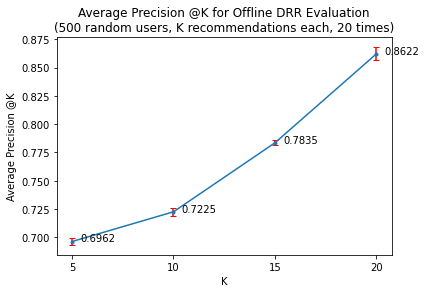

In [26]:
offline_eval_data = [drr_fives, drr_tens, drr_fifteens, drr_twenties]

offline_means, offline_stds = [], []

for d in offline_eval_data:
    offline_means.append(np.mean(d))
    offline_stds.append(np.std(d))

title = "Average Precision @K for Offline DRR Evaluation\n(500 random users, K recommendations each, 20 times)"
ylabel = "Average Precision @K"
xlabel = "K"
output = "logs/drr_eval.png"
x = T_precisions
y = offline_means
e = offline_stds
e_x_off = 0.4
e_y_off = 0
    
plt.figure()
plt.errorbar(x, y, yerr=e, fmt='.-', ecolor="red", capsize=3)
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xticks(x)
for i, j in zip(x, y):
    plt.annotate(str(round(j, 4)), xy=(i+e_x_off, j+e_y_off))

plt.savefig(output)